In [1]:
import torch 
import torch.nn as nn
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from mlxtend.plotting import plot_decision_regions 


In [3]:
x,y = make_moons(1000, noise=0.25, random_state=2)

In [16]:
y

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0,

In [4]:
x

array([[ 0.58600438,  0.699994  ],
       [ 1.00076618, -0.4782937 ],
       [ 1.65756376, -0.11744784],
       ...,
       [-0.73896793,  0.27664436],
       [ 0.08163876,  0.09930468],
       [ 0.73419605,  0.90928752]])

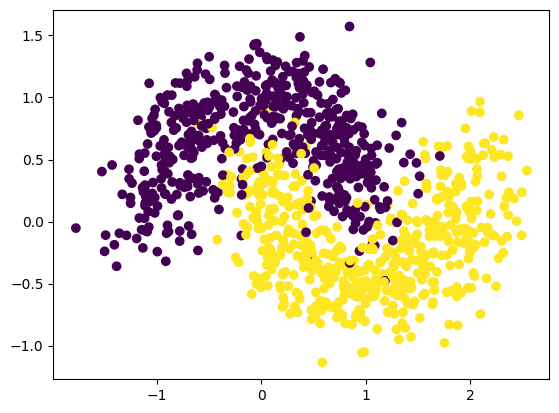

In [5]:
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

In [6]:
class classifier(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(n_classes,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
        
    def forward(self,x):
        x = self.nn(x)
        x = torch.sigmoid(x)
        return x 

In [15]:
from torchsummary import summary

model = classifier(n_classes=2)  
summary(model, input_size=(2,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 1]             129
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [17]:
from sklearn.model_selection import train_test_split    

x_train, x_test, y_train,y_test = train_test_split(x,y, test_size=0.2, random_state =42)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [18]:
x_train_tensor.shape

torch.Size([800, 2])

In [19]:
import torch.optim as optim

model = classifier(n_classes=2)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [21]:
epochs = 2000  # for overfitting

for epoch in range(epochs):
    outputs = model(x_train_tensor)
    loss = loss_fn(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        
        
with torch.no_grad():
    
    train_logits = model(x_train_tensor)
    train_probs = torch.sigmoid(train_logits)
    train_preds = (train_probs > 0.5).float()
    train_acc = (train_preds.eq(y_train_tensor).sum().item()) / len(y_train)
    
    logits = model(x_test_tensor)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    acc = (preds.eq(y_test_tensor).sum().item()) / len(y_test_tensor)
    
    
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {acc*100:.2f}%")    

Epoch [10/2000], Loss: 0.0745
Epoch [20/2000], Loss: 0.0547
Epoch [30/2000], Loss: 0.0465
Epoch [40/2000], Loss: 0.0419
Epoch [50/2000], Loss: 0.0396
Epoch [60/2000], Loss: 0.0381
Epoch [70/2000], Loss: 0.0373
Epoch [80/2000], Loss: 0.0366
Epoch [90/2000], Loss: 0.0364
Epoch [100/2000], Loss: 0.0359
Epoch [110/2000], Loss: 0.0356
Epoch [120/2000], Loss: 0.0353
Epoch [130/2000], Loss: 0.0350
Epoch [140/2000], Loss: 0.0347
Epoch [150/2000], Loss: 0.0343
Epoch [160/2000], Loss: 0.0341
Epoch [170/2000], Loss: 0.0338
Epoch [180/2000], Loss: 0.0338
Epoch [190/2000], Loss: 0.0335
Epoch [200/2000], Loss: 0.0332
Epoch [210/2000], Loss: 0.0330
Epoch [220/2000], Loss: 0.0328
Epoch [230/2000], Loss: 0.0326
Epoch [240/2000], Loss: 0.0325
Epoch [250/2000], Loss: 0.0323
Epoch [260/2000], Loss: 0.0321
Epoch [270/2000], Loss: 0.0319
Epoch [280/2000], Loss: 0.0315
Epoch [290/2000], Loss: 0.0312
Epoch [300/2000], Loss: 0.0311
Epoch [310/2000], Loss: 0.0309
Epoch [320/2000], Loss: 0.0307
Epoch [330/2000],

In [23]:
class classifier_model(nn.Module):
    def __init__(self, n_classes=2, use_dropout=False):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(n_classes, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,1)            
        )
        
    def forward(self, x):
        x = self.nn(x)
        return x 
    

In [27]:
model  = classifier_model(n_classes=2,use_dropout=True)

loss_fn2 = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 1e-4)


epochs = 2000

for epoch in range(epochs):
    model.train()
    outputs = model(x_train_tensor)
    loss = loss_fn2(outputs, y_train_tensor)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 500 == 0:
        print(f'[{epoch+1}/{epochs}] Loss: {loss.item():.4f}')
        
    
    # eval 

with torch.no_grad():
    
    train_logits = model(x_train_tensor)
    train_probs = torch.sigmoid(train_logits)
    train_preds = (train_probs > 0.5).float()
    train_acc = (train_preds.eq(y_train_tensor).sum().item()) / len(y_train)
    
    logits = model(x_test_tensor)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    acc = (preds.eq(y_test_tensor).sum().item()) / len(y_test_tensor)
    
    
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {acc*100:.2f}%") 
    

[500/2000] Loss: 0.1582
[1000/2000] Loss: 0.1490
[1500/2000] Loss: 0.1462
[2000/2000] Loss: 0.1505
Train Accuracy: 94.88%
Test Accuracy: 95.50%


In [ ]:
# accuracy improved on using dropouts 